In [6]:
# Author Q.Liu
# Date: 27/09/2017
# Exercise 5 - object description
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import numpy as np
import cv2
from skimage import morphology
from scipy.ndimage.morphology import binary_fill_holes

print('Opencv version: ', cv2.__version__)
# useful link for check opencv version before call some functions
# https://www.pyimagesearch.com/2015/08/10/checking-your-opencv-version-using-python/


Opencv version:  3.3.0


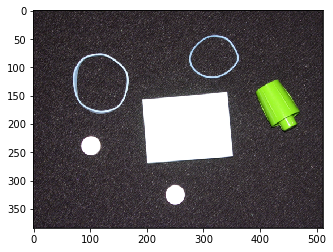

In [8]:
# Task1 recognition of round objects
# image = pillsetc.png, download from https://ojskrede.github.io/inf4300/images/

# step1 read image by cv2
image_file = './images/pillsetc.png'
img = cv2.imread(image_file)
imshow(img)

In [9]:
# step2 cvt to binary img with otsu thresholding by cv2
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
otsu_th, otsu_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU)

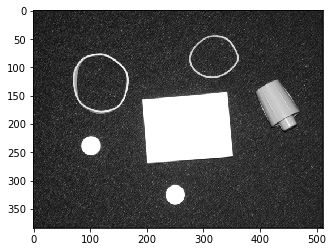

In [52]:
imshow(gray_img)


Otsu threshold:  146.0


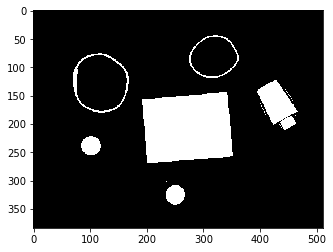

In [53]:
imshow(otsu_img)

print('Otsu threshold: ', otsu_th)

In [14]:
# step3 remove noise
# revove pixels which not belong to the object of interest.
# in our case, remove objects containing less than 30 pixels
rm_img = morphology.remove_small_objects(otsu_img.astype(bool), min_size=30)
fil_img = binary_fill_holes(rm_img) # fill holes

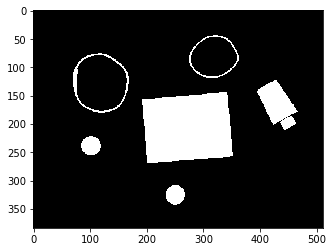

In [54]:
imshow(rm_img)


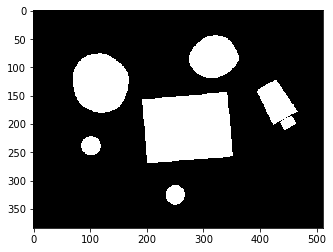

In [55]:
imshow(fil_img)


In [19]:
# find boundaries, using opencv findContours() function
# Contours can be explained simply as a curve joining 
# all the continuous points (along the boundary), having same color or intensity.

# label_image, contours, hierarchy = cv2.findContours() 
_,contours,_ = cv2.findContours(rm_img.astype(np.uint8), 
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_NONE)


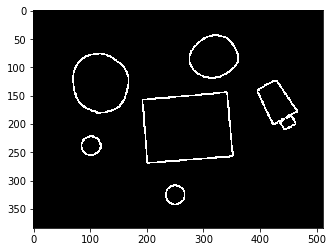

In [163]:
# Draw contours
obj_img = np.zeros(rm_img.shape)
cv2.drawContours(obj_img, contours, -1, 1, 2)
imshow(obj_img)


In [164]:
# using different colors
# redraw contours and ojects

for ind, contour in enumerate(contours): # in this case ind=0-5 
    color_val = 255*(ind + 1) / len(contours)
    cv2.drawContours(obj_img, [contour], 0, color_val, -1)
 

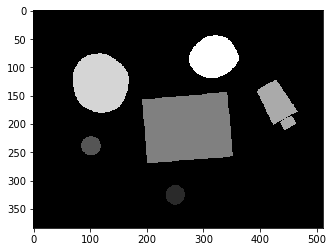

In [165]:
imshow(obj_img)


In [120]:
# step5 determine round objects
# round object's area - A with its circumference/perimeter - P has the relation
# A = P^2 / 4*pi      or 
# 4 * pi * A / P^2 = 1
# for example
def likelihood(A=1, P=3.6):
    pi = 3.1416
    return (4 * pi * A / P**2)


print(likelihood())

0.9696296296296295


Object-0
Area:880.0,Perimeter:110.56854249492382, Probability of circle:0.9045454265482717
Object-1
Area:876.0,Perimeter:110.56854249492382, Probability of circle:0.9004338564275977
Object-2
Area:16914.0,Perimeter:543.0538238691624, Probability of circle:0.720728098087339
Object-3
Area:3284.0,Perimeter:306.33304448274095, Probability of circle:0.43977074341851086
Object-4
Area:8043.0,Perimeter:345.7056274847714, Probability of circle:0.8456994535655454
Object-5
Area:4884.5,Perimeter:264.0071426749364, Probability of circle:0.880642498271272


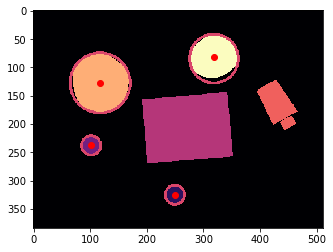

In [156]:
# show object img with different colors
imshow(obj_img.astype(np.uint8), cmap='magma', interpolation='none')

# Now need to calculate area and circumference of an object by contours data
# contour is a list of N coordinate points (Xi, Yi), i from 0 to N-1
for ind, contour in enumerate(contours): 
    #delta_xy = np.diff(contour, axis=0)   # first compute Xi+1 - Xi, Yi+1 - Y
    d_xy = np.diff(contour, axis=0)
    d_x = d_xy[:,:,0]
    d_y = d_xy[:,:,1]    
    d_x2y2 = d_x**2 + d_y**2 # compute (Xi+1 - Xi)^2 + (Yi+1 - Y)^2

    P1 = np.sum(np.sqrt(d_x2y2)) + 1 # should plus the length of end-point to start-point, approxi 1
    
    # opencv also provides a built-in function arcLenght() to calculate perimeter of any arc
    P2 = cv2.arcLength(contour, True)
    A = cv2.contourArea(contour)
    Prob = likelihood(A,P1)
    
    print('Object-{0}'.format(ind))
    print('Area:{0},Perimeter:{1}, Probability of circle:{2}'.format(A, P1, Prob))
    
    # function cv2.moments() gives a dictionary of all moment values calculated
    # Centroid is given by the relations, Cx=M10/M00 and Cy=M01/M00
    
    if Prob > 0.80: # can
        moments = cv2.moments(contour)
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        plot(cx,cy,'ro')
        #  draw a circle which completely covers the object
        (x,y),radius = cv2.minEnclosingCircle(contour)
        center = (int(x),int(y))
        radius = int(radius)
        cv2.circle(obj_img,center,radius,(150,255,110),3)

    

In [178]:
# wrapping up to a general function
def find_circle(gray_img, prob=0.8):
    otsu_th, otsu_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU)
    rm_img = morphology.remove_small_objects(otsu_img.astype(bool), min_size=30)
    obj_img = np.zeros(rm_img.shape)
    # redraw contours and ojects

    for ind, contour in enumerate(contours): # in this case ind=0-5 
        color_val = 255*(ind + 1) / len(contours)
        cv2.drawContours(obj_img, [contour], 0, color_val, -1)
        
        P = cv2.arcLength(contour, True)
        A = cv2.contourArea(contour)
        Prob = likelihood(A,P)
        if Prob > prob: 
            #  draw a circle which completely covers the object
            (x,y),radius = cv2.minEnclosingCircle(contour)
            center = (int(x),int(y))
            radius = int(radius)
            cv2.circle(obj_img, center, radius,(150,255,10),3)
            
    return obj_img

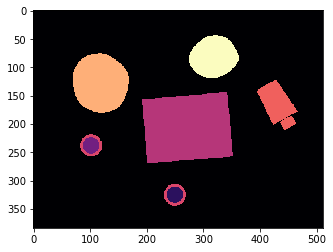

In [181]:
imshow(find_circle(gray_img, 0.9),cmap='magma', interpolation='none')

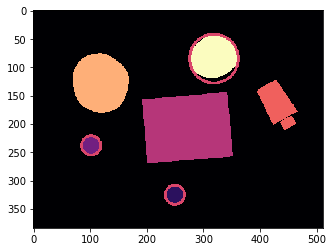

In [182]:
imshow(find_circle(gray_img, 0.85),cmap='magma', interpolation='none')

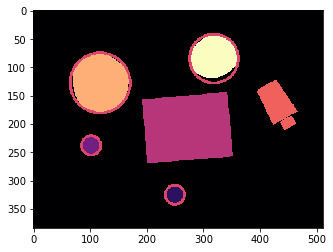

In [183]:
imshow(find_circle(gray_img, 0.80),cmap='magma', interpolation='none')

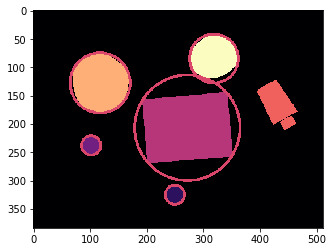

In [184]:
imshow(find_circle(gray_img, 0.70),cmap='magma', interpolation='none')